In [1]:
import os
import glob
import json
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
from scipy.stats import spearmanr, pearsonr
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from PIL import Image
import matplotlib
Image.MAX_IMAGE_PIXELS = None
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../..")
from digitalhistopathology.clustering.clustering_utils import plot_ari_scores_all_patients
from digitalhistopathology.benchmark.benchmark_clustering import BenchmarkClustering

2025-12-17 12:54:18.454679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software.9/software/code-server/4.93.1/lib
2025-12-17 12:54:18.454763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software.9/software/code-server/4.93.1/lib
2025-12-17 12:54:18.454771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


/storage/homefs/ll25y867/.conda/envs/digitalhisto/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


# Unsupervised Clustering of HER2 dataset
This notebook contains the code to realize the plots of the unsupervised clustering of the HER2 dataset for the **base models**.

In [2]:
# Load configuration file
with open("../../config/config_notebooks_HER2.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
# Initialize the BenchmarkClustering object
saving_folder=os.path.join(config['base_benchmark_folder'], "unsupervised_clustering_ARI", "kmeans")
extension='pdf'

benchmark_clustering = BenchmarkClustering(
    path_to_pipeline=config['path_to_base_pipelines'],
    pipelines_list=config['base_model_list'],
    results_folder="../results",
    saving_folder=saving_folder,
    dataset=config['dataset'],
    extension=extension
    )

['uni', 'uni2', 'virchow', 'provgigapath', 'ctranspath', 'simclr']
<class 'list'>
Label files: []


In [4]:
# Set the variables
palette = sns.set_palette(config["base_color_palette"])
base_model_palette = config["base_model_palette"]
base_model_list = config["base_model_list"]
benchmark_folder = config["base_benchmark_folder"]

# Create the results folders
os.makedirs(os.path.join(config['figures_folder'], "Figure2"), exist_ok=True)
os.makedirs(os.path.join(config['figures_folder'], "Figure3"), exist_ok=True)
os.makedirs(os.path.join(config['figures_folder'], "Figure4"), exist_ok=True)
os.makedirs(os.path.join(config['figures_folder'], "Figure5"), exist_ok=True)

## Comparison between linear and unlinear clustering

In [5]:
# LOad the results
try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans', 'unsupervised_clustering_results_optk.json')) as f:
        raw_clust = json.load(f)
except:
    raw_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='raw')

try:
    with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'kmeans',  'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
        svd_clust = json.load(f)
except:
    svd_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='svd5')

umap_clust = benchmark_clustering.get_best_UMAP_ari_per_slide(force_loading=True)

# Add handcrafted features
umap_clust["handcrafted_features"] = {}
for file in glob.glob(os.path.join(benchmark_clustering.saving_folder, f'best_umap_ari_model_handcrafted_features_patient_*.json')):
    patient_name = os.path.basename(file).split("_patient_")[1].split('.json')[0]
    with open(file, 'r') as f:
        umap_clust["handcrafted_features"][patient_name] = json.load(f)


Embeddings per patient: None
Force loading best UMAP parameters for model uni2 for existing patients...
Force loading best UMAP parameters for model handcrafted_features for existing patients...
Force loading best UMAP parameters for model simclr for existing patients...
Force loading best UMAP parameters for model provgigapath for existing patients...
Force loading best UMAP parameters for model ctranspath for existing patients...
Force loading best UMAP parameters for model virchow for existing patients...
Force loading best UMAP parameters for model uni for existing patients...


In [6]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari all: {raw_clust[model]['all']['ari']}, ari mean: {raw_clust[model]['mean']['ari']}")

Model: uni: ari all: 0.1405392782347744, ari mean: 0.2351268295263375
Model: uni2: ari all: 0.18521218744767412, ari mean: 0.2679689887382149
Model: virchow: ari all: 0.1183085728713925, ari mean: 0.17190180596666965
Model: provgigapath: ari all: 0.17792105308917527, ari mean: 0.21482550933591596
Model: ctranspath: ari all: 0.13713016500660263, ari mean: 0.19542486389103267
Model: simclr: ari all: 0.12163234853750751, ari mean: 0.1942217274165287
Model: handcrafted_features: ari all: 0.10094446204343024, ari mean: 0.11174721697791898


In [7]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari tumor: {raw_clust[model]['ARI_tumor']}")

Model: uni: ari tumor: 0.14775572194802
Model: uni2: ari tumor: 0.1864012080313909
Model: virchow: ari tumor: 0.10255900228781585
Model: provgigapath: ari tumor: 0.15293057564211432
Model: ctranspath: ari tumor: 0.13812792738857277
Model: simclr: ari tumor: 0.1309163343846592
Model: handcrafted_features: ari tumor: 0.08584559722543653


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


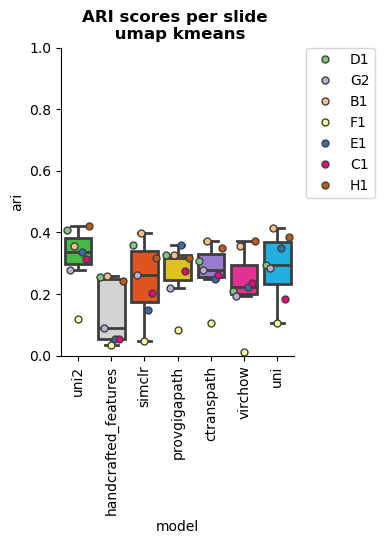

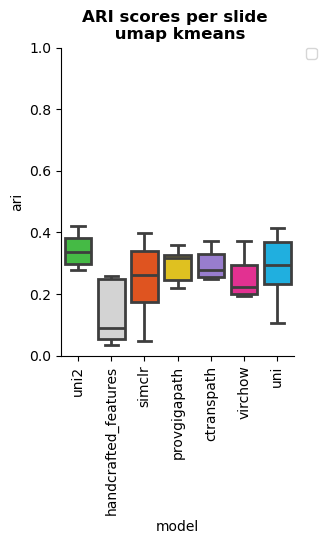

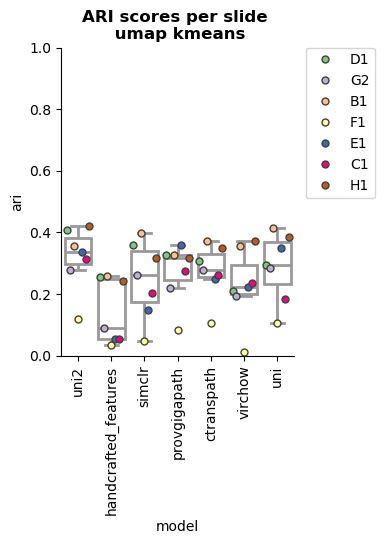

In [8]:
%matplotlib inline

plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), color_boxes=True, palette=base_model_palette)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_colored_with_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()
    
plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), stripplot=False, color_boxes=True, palette=base_model_palette)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_colored_without_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()
    
plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), stripplot=True, color_boxes=False)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_no_color_with_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'ARI scores per slide \n UMAP k-means')

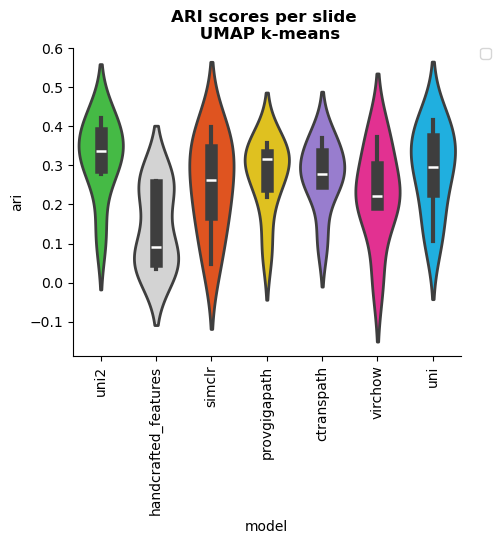

In [9]:
ari_scores = {}
for model in umap_clust.keys():
    ari_scores[model] = {}
    for patient in umap_clust[model].keys():
        if (patient != 'all') and (patient != 'mean'):
            ari_scores[model][patient] = umap_clust[model][patient]['ari']
df_aris = pd.DataFrame.from_dict(ari_scores)
df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)

plt.figure(figsize=(5,4))
sns.violinplot(data=df_aris_melted, x='model', y='ari', hue='model', linewidth=2, palette=base_model_palette)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.title(f'ARI scores per slide \n UMAP k-means', weight='bold')

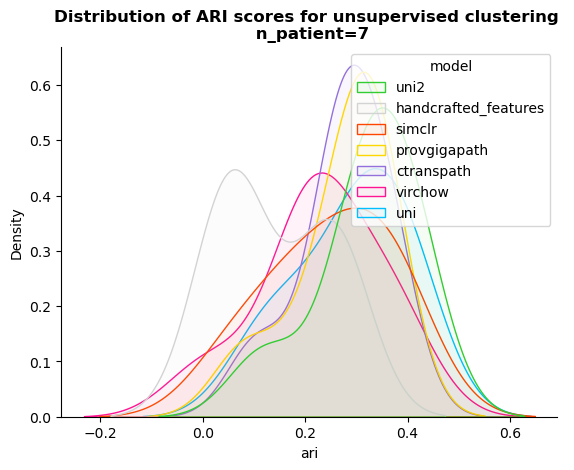

In [10]:
sns.kdeplot(data=df_aris_melted, x='ari', hue='model', fill=True, alpha=0.05, palette=base_model_palette)
sns.despine()
plt.title(f'Distribution of ARI scores for unsupervised clustering \n n_patient={len(list(umap_clust[list(umap_clust.keys())[0]].keys()))}', weight='bold')
plt.show()

In [11]:
dfs_clust = []
for clustering_dict, method in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):
    ari_scores = {}
    for model in clustering_dict.keys():
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            if patient != "ARI_tumor":
            #if (patient != 'all') and (patient != 'mean'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)
    df_aris_melted['clustering'] = method
    dfs_clust.append(df_aris_melted)

df_comp = pd.concat(dfs_clust)

In [12]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').agg(['mean', 'std'])

ari          
                          mean       std
model                                   
ctranspath            0.188948  0.091898
handcrafted_features  0.110547  0.087322
provgigapath          0.210725  0.093010
simclr                0.186156  0.108977
uni                   0.224617  0.094085
uni2                  0.258774  0.105284
virchow               0.165947  0.104048

In [13]:
# Correlation with shannon entropy
with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")) as f:
    shannon_entropy = json.load(f)

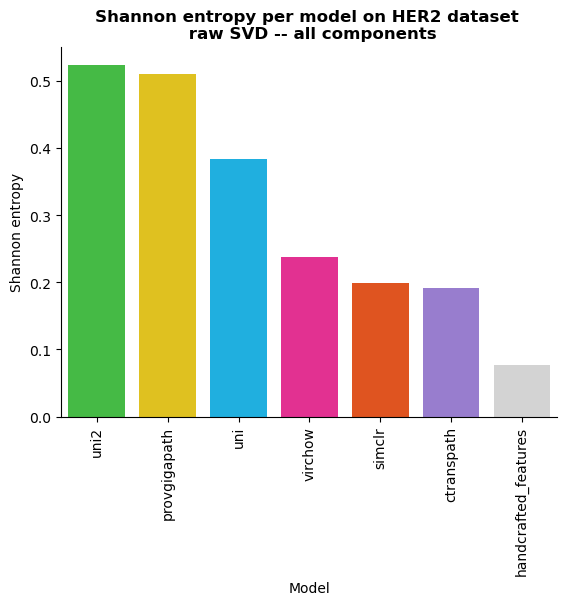

In [14]:
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

df_shannon.sort_values('shannon_entropy', inplace=True, ascending=False)
sns.barplot(data=df_shannon, 
            x=df_shannon.index, 
            y='shannon_entropy', 
            hue=df_shannon.index, palette=base_model_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel("Shannon entropy")
plt.title(f"Shannon entropy per model on {config['dataset']} dataset \n raw SVD -- all components", weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy.pdf"), bbox_inches='tight')

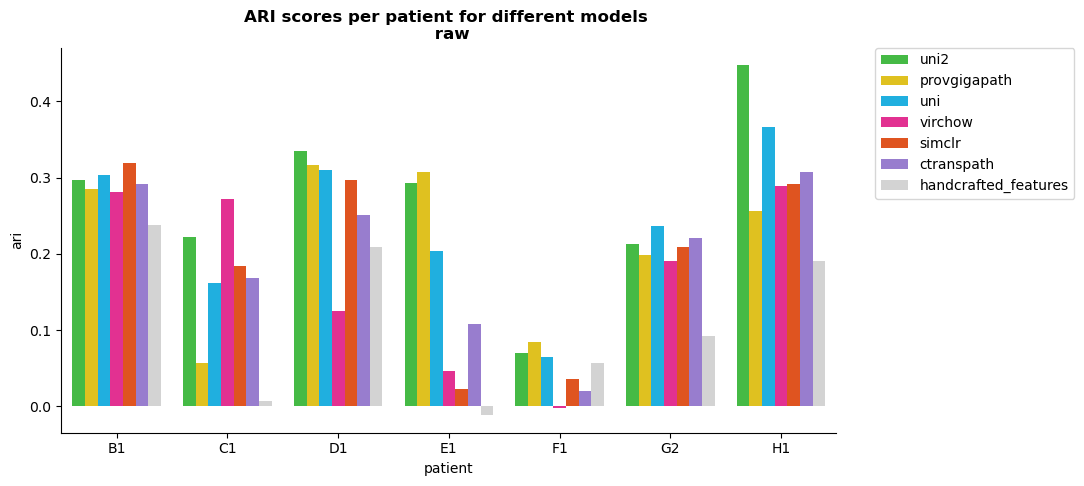

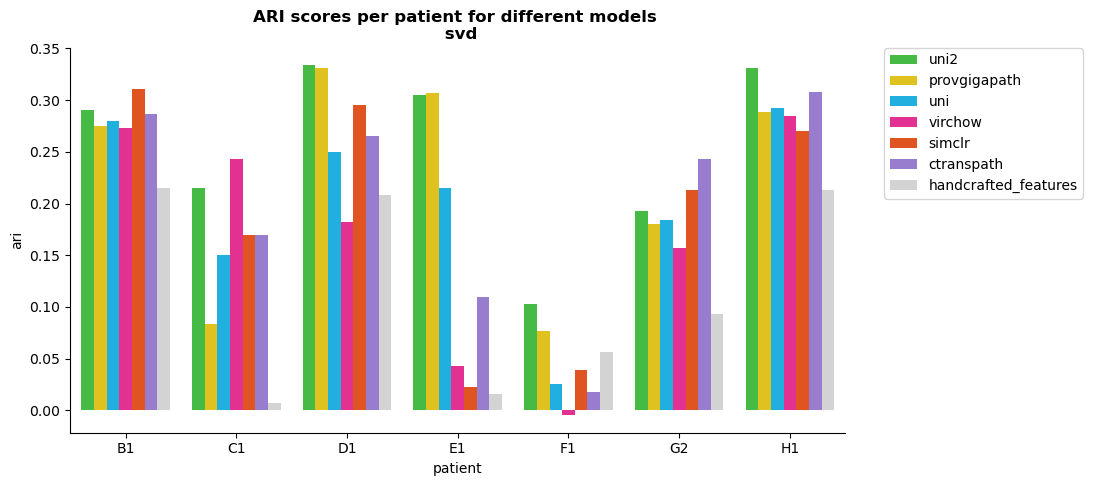

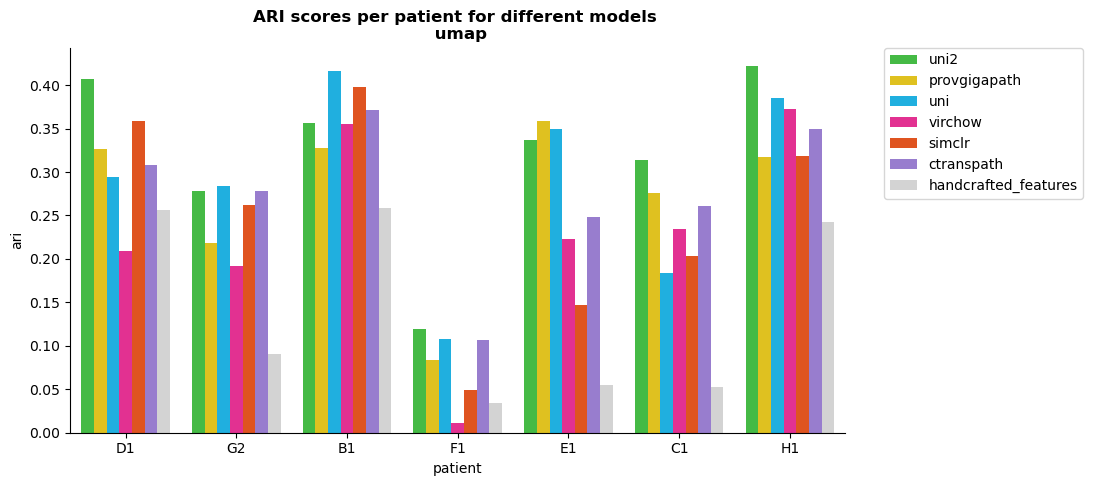

In [15]:
# ARI scores 
for method in ["raw", "svd", "umap"]:
    ordered_dfs = []

    for model in df_shannon.index:
        ordered_dfs.append(df_comp[(df_comp['model'] == model) & (df_comp["clustering"] == method) & (df_comp['patient'] != 'all') & (df_comp['patient'] != 'mean')])

    df_comp_method = pd.concat(ordered_dfs)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_comp_method, x='patient', y='ari', hue='model', palette=base_model_palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.title(f'ARI scores per patient for different models \n {method}', weight='bold')

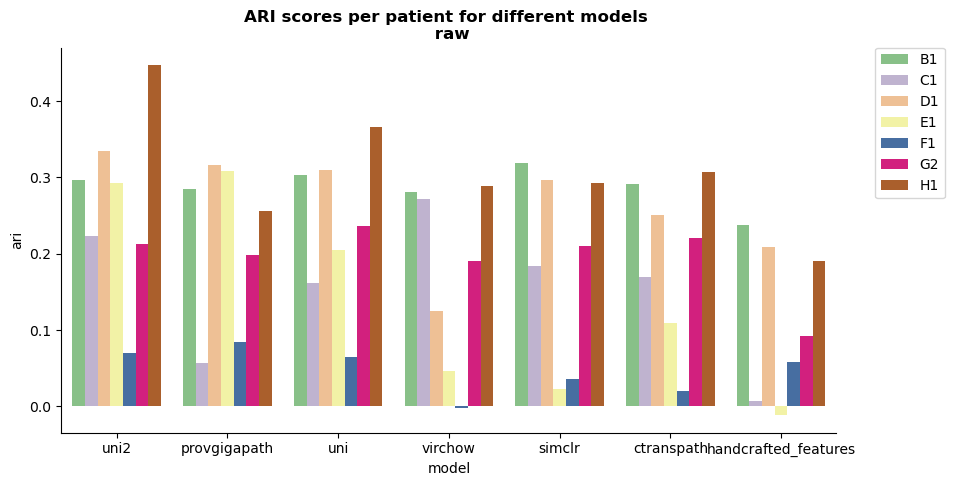

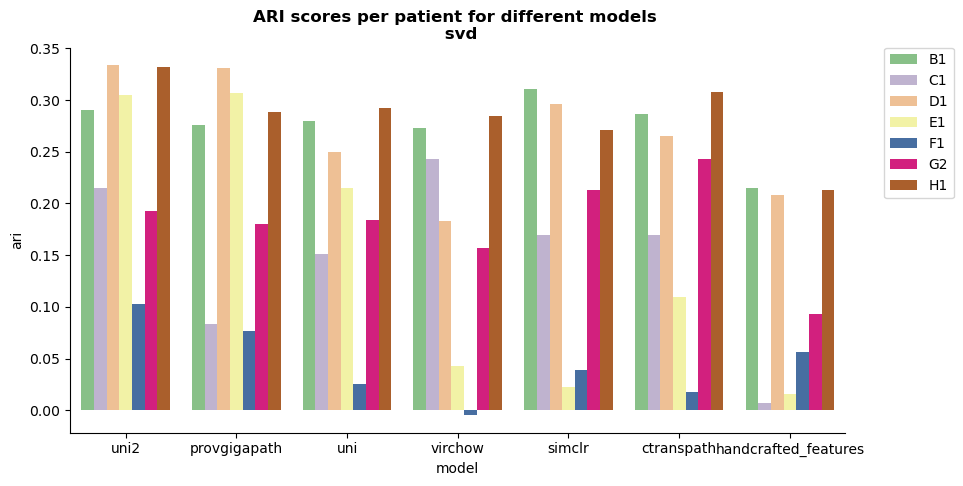

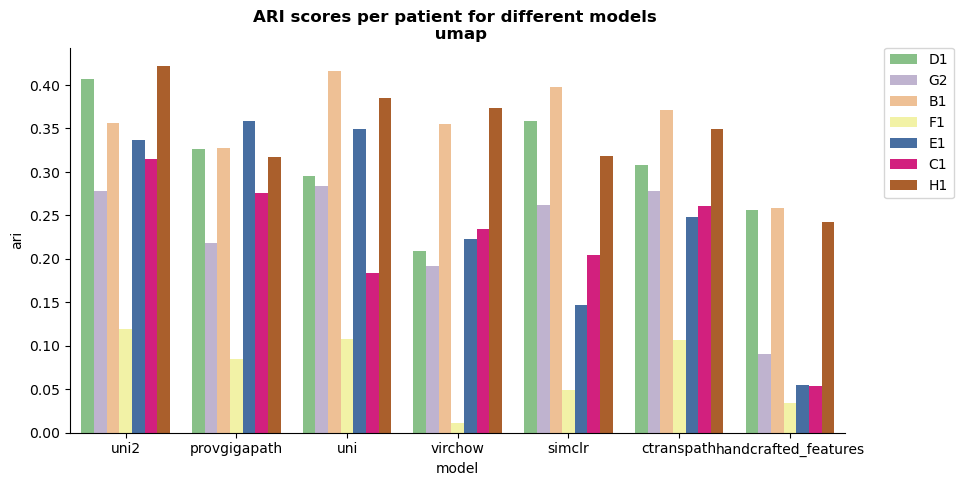

In [16]:
# ARI scores 
for method in ["raw", "svd", "umap"]:
    ordered_dfs = []

    for model in df_shannon.index:
        ordered_dfs.append(df_comp[(df_comp['model'] == model) & (df_comp["clustering"] == method) & (df_comp['patient'] != 'all') & (df_comp['patient'] != 'mean')])

    df_comp_method = pd.concat(ordered_dfs)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_comp_method, x='model', y='ari', hue='patient', palette="Accent")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.title(f'ARI scores per patient for different models \n {method}', weight='bold')

In [17]:
def make_spider(df, row, color, title):
    
    categories=list(df)[0:]
    N = len(categories)

    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5))
 
    ax = plt.subplot(1,1,1, polar=True)

    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3,0.4], ["0.1","0.2","0.3","0.4"], color="black", size=10)
    plt.ylim(0,0.55)

    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.1)
  
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)

In [18]:
df_comp_patient = df_comp[df_comp["patient"].isin(["A1", "B1", "C1", "D1", "E1", "F1", "G2", "H1"])]


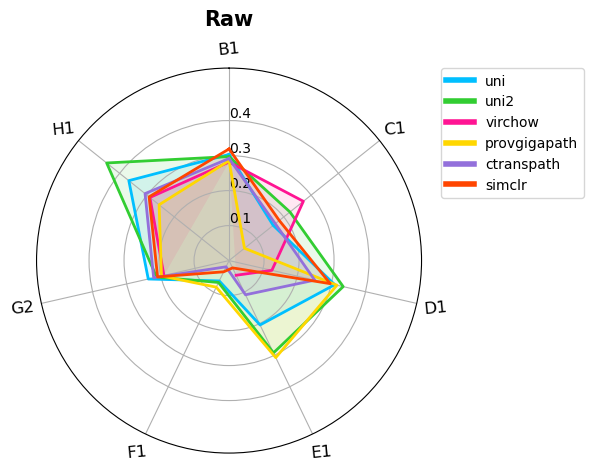

In [19]:
for model in base_model_list:
    d_test = df_comp_patient[(df_comp_patient["model"] == model) & (df_comp_patient["clustering"] == "raw")].T
    d_test.columns = d_test.loc['patient'].values
    make_spider(d_test, row=1, color=base_model_palette[model], title=model)
    plt.title("Raw", weight='bold', y=1.09, fontsize=15)

handles = [plt.Line2D([0], [0], color=base_model_palette[model], lw=4) for model in base_model_list]
plt.legend(handles, base_model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(config['figures_folder'], "Figure2/unsupervised_clustering_radarplot_raw.pdf"), bbox_inches='tight')

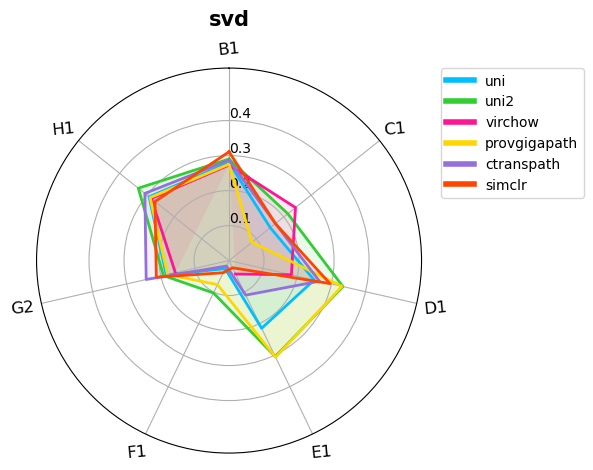

In [20]:
for model in base_model_list:
    d_test = df_comp_patient[(df_comp_patient["model"] == model) & (df_comp_patient["clustering"] == "svd")].T
    d_test.columns = d_test.loc['patient'].values
    make_spider(d_test, row=1, color=base_model_palette[model], title=model)
    plt.title("svd", weight='bold', y=1.09, fontsize=15)
    
handles = [plt.Line2D([0], [0], color=base_model_palette[model], lw=4) for model in base_model_list]
plt.legend(handles, base_model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(config['figures_folder'], "Figure2/unsupervised_clustering_radarplot_svd.pdf"), bbox_inches='tight')

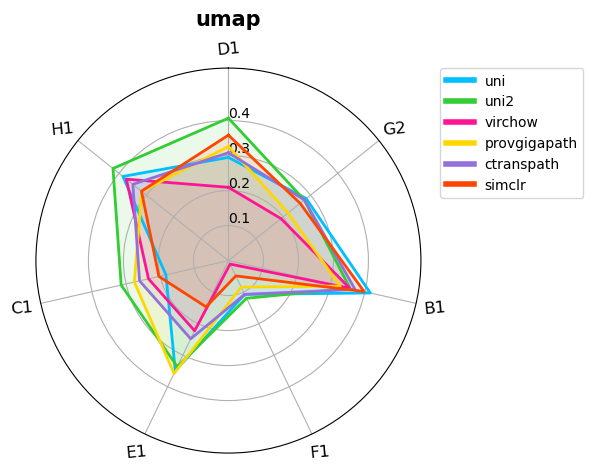

In [21]:
for model in base_model_list:
    d_test = df_comp_patient[(df_comp_patient["model"] == model) & (df_comp_patient["clustering"] == "umap")].T
    d_test.columns = d_test.loc['patient'].values
    make_spider(d_test, row=1, color=base_model_palette[model], title=model)
    plt.title("umap", weight='bold', y=1.09, fontsize=15)
handles = [plt.Line2D([0], [0], color=base_model_palette[model], lw=4) for model in base_model_list]
plt.legend(handles, base_model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.savefig(os.path.join(config['figures_folder'], "Figure2/unsupervised_clustering_radarplot_umap.pdf"), bbox_inches='tight')

In [22]:
ari_raw = pd.DataFrame.from_dict({model: {patient: raw_clust[model][patient]['ari'] for patient in raw_clust[model].keys() if patient not in ["ARI_tumor"]} for model in raw_clust.keys()})
df_raw_overall = pd.DataFrame(ari_raw.loc["all"])
df_raw_overall.columns = ['ari']

ari_svd = pd.DataFrame.from_dict({model: {patient: svd_clust[model][patient]['ari'] for patient in svd_clust[model].keys()  if patient != 'ARI_tumor'} for model in svd_clust.keys()})
df_svd_overall = pd.DataFrame(ari_svd.loc["all"])
df_svd_overall.columns = ['ari']

In [23]:
ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()   

Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...
Computing best UMAP parameters for model uni2...
Loading best UMAP parameters for model uni2...
Computing best UMAP parameters for model virchow...
Loading best UMAP parameters for model virchow...
Computing best UMAP parameters for model provgigapath...
Loading best UMAP parameters for model provgigapath...
Computing best UMAP parameters for model ctranspath...
Loading best UMAP parameters for model ctranspath...
Computing best UMAP parameters for model simclr...
Loading best UMAP parameters for model simclr...


In [24]:
try:
    with open(os.path.join(config['base_benchmark_folder'], 'unsupervised_clustering_ARI', 'kmeans', f'best_umap_ari_overall.json')) as f:
        ari_umap_overall = json.load(f)
except:
    ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()
ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()   
df_umap_overall = pd.DataFrame(ari_umap_overall).T[['ari']]


Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...
Computing best UMAP parameters for model uni2...
Loading best UMAP parameters for model uni2...
Computing best UMAP parameters for model virchow...
Loading best UMAP parameters for model virchow...
Computing best UMAP parameters for model provgigapath...
Loading best UMAP parameters for model provgigapath...
Computing best UMAP parameters for model ctranspath...
Loading best UMAP parameters for model ctranspath...
Computing best UMAP parameters for model simclr...
Loading best UMAP parameters for model simclr...


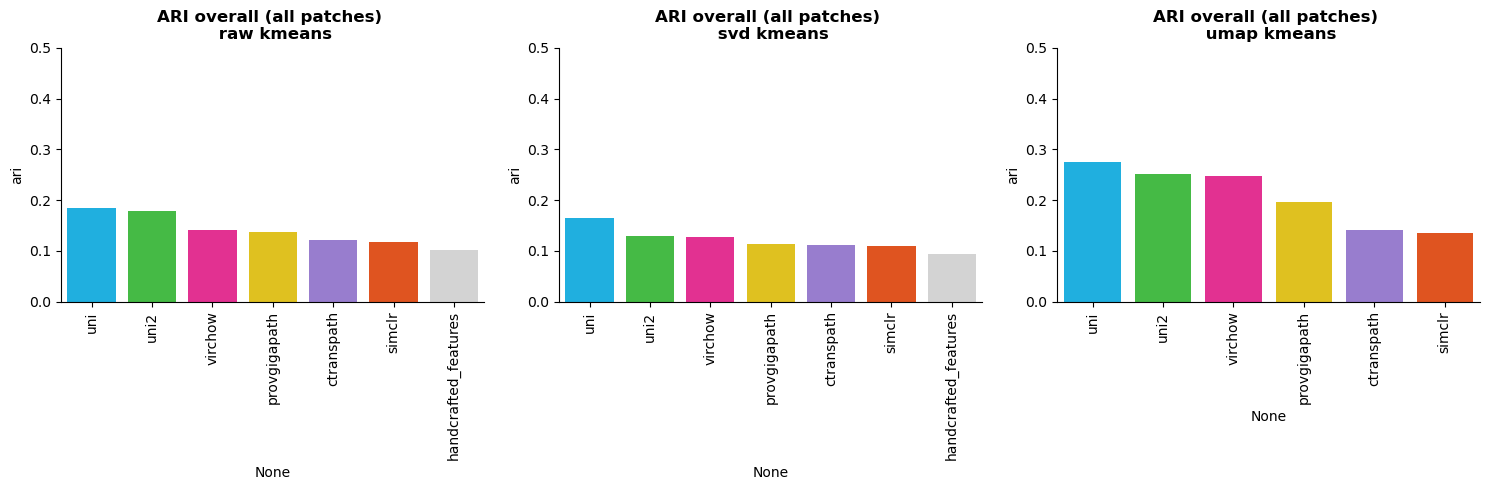

In [25]:
plt.figure(figsize=(15, 5))

names = ["raw kmeans", "svd kmeans", "umap kmeans"]

for i, df_ari_overall in enumerate([df_raw_overall, df_svd_overall, df_umap_overall]):
    plt.subplot(1, 3, 1 + i)
    sns.barplot(data=df_ari_overall.sort_values("ari", ascending=False), x=df_ari_overall.index, y="ari", hue=df_ari_overall.index, palette=base_model_palette)
    plt.xticks(rotation=90)
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 0.5)
    plt.title(f"ARI overall (all patches) \n {names[i]}", weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure2/unsupervised_clustering_raw_svd_umap_barplot.pdf"), bbox_inches='tight')

## Correlation ARI and shannon entropy

In [26]:
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

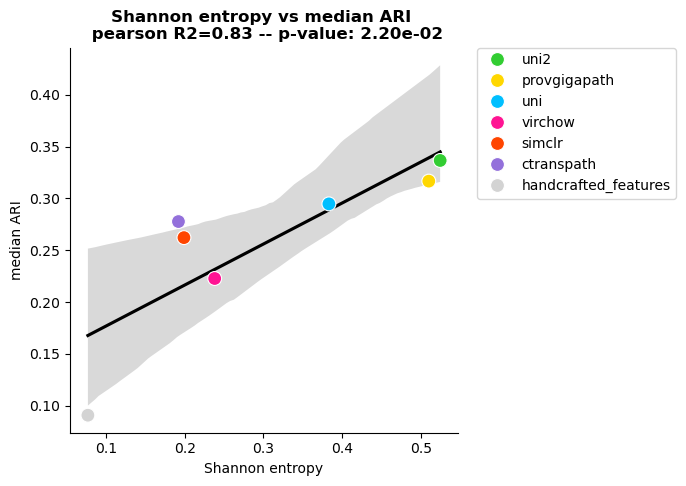

In [27]:
median_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').median()
median_ari_per_model.columns = ['median_ari']
df_model_summary = df_shannon.merge(median_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['median_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='median_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='median_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100, zorder=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('median ARI')
plt.title(f'Shannon entropy vs median ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_median_ari.pdf"), bbox_inches='tight')

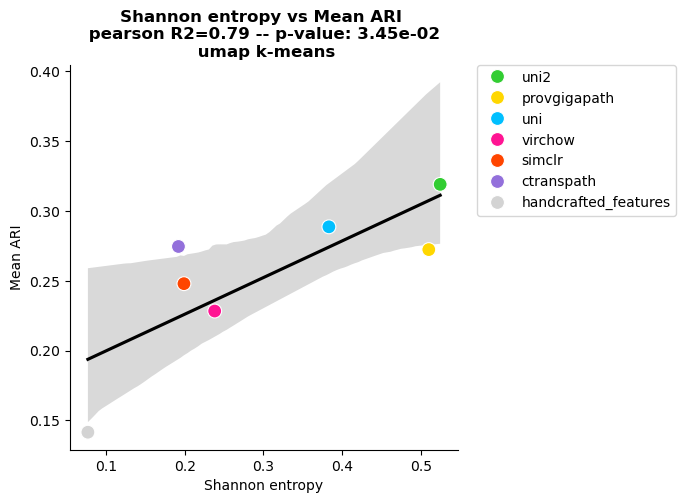

In [28]:
mean_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']
df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e} \n umap k-means', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_mean_ari_umapkmeans.pdf"), bbox_inches='tight')

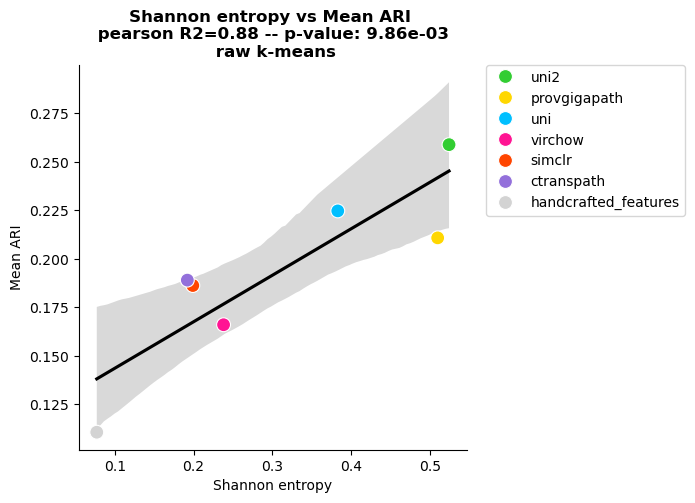

In [29]:
mean_ari_per_model = df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']
df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e} \n raw k-means', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_mean_ari_rawkmeans.pdf"), bbox_inches='tight')

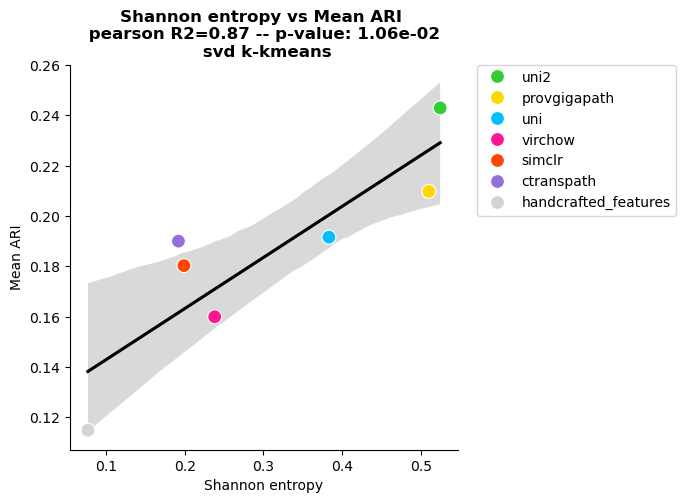

In [30]:
mean_ari_per_model = df_comp[df_comp['clustering'] == 'svd'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']
df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e} \n svd k-kmeans', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_mean_ari_svdkmeans.pdf"), bbox_inches='tight')

In [31]:
overall_umap = benchmark_clustering.get_best_UMAP_ari_overall(annotated_only=True)
    
overall_umap_aris = {}
for model in overall_umap.keys():
    overall_umap_aris[model] = overall_umap[model]['ari']

overall_umap_aris["handcrafted_features"] = json.load(open(os.path.join(benchmark_clustering.saving_folder, f'best_umap_ari_model_handcrafted_features_all_annotated_only.json')))['ari']

df_model_summary['overall_ari'] = pd.Series(overall_umap_aris)

Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...
Computing best UMAP parameters for model uni2...
Loading best UMAP parameters for model uni2...
Computing best UMAP parameters for model virchow...
Loading best UMAP parameters for model virchow...
Computing best UMAP parameters for model provgigapath...
Loading best UMAP parameters for model provgigapath...
Computing best UMAP parameters for model ctranspath...
Loading best UMAP parameters for model ctranspath...
Computing best UMAP parameters for model simclr...
Loading best UMAP parameters for model simclr...


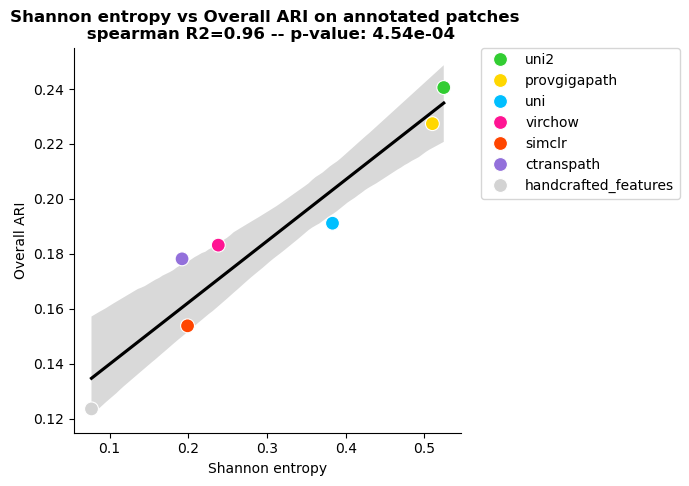

In [32]:
s, p = spearmanr(df_model_summary['shannon_entropy'], df_model_summary['overall_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Overall ARI')
plt.title(f'Shannon entropy vs Overall ARI on annotated patches \n spearman R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_overall_ari_annotated_only.pdf"), bbox_inches='tight')

Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...
Computing best UMAP parameters for model uni2...
Loading best UMAP parameters for model uni2...
Computing best UMAP parameters for model virchow...
Loading best UMAP parameters for model virchow...
Computing best UMAP parameters for model provgigapath...
Loading best UMAP parameters for model provgigapath...
Computing best UMAP parameters for model ctranspath...
Loading best UMAP parameters for model ctranspath...
Computing best UMAP parameters for model simclr...
Loading best UMAP parameters for model simclr...


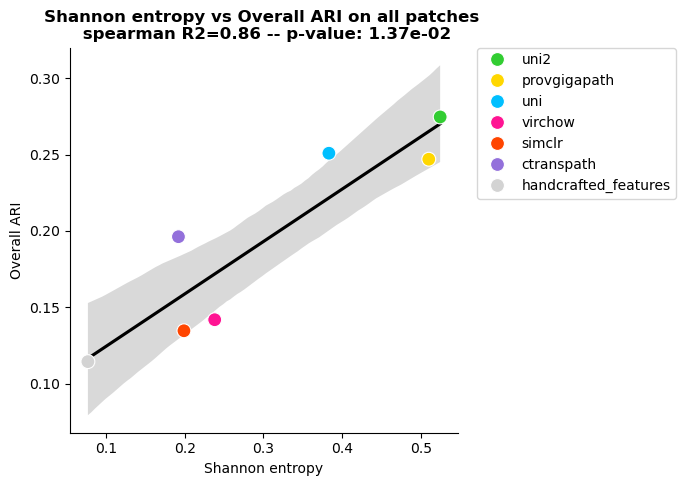

In [33]:
overall_umap = benchmark_clustering.get_best_UMAP_ari_overall()
    
overall_umap_aris = {}
for model in overall_umap.keys():
    overall_umap_aris[model] = overall_umap[model]['ari']
overall_umap_aris["handcrafted_features"] = json.load(open(os.path.join(benchmark_clustering.saving_folder, f'best_umap_ari_model_handcrafted_features_all.json')))['ari']

df_model_summary['overall_ari'] = pd.Series(overall_umap_aris)

s, p = spearmanr(df_model_summary['shannon_entropy'], df_model_summary['overall_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', hue=df_model_summary.index,
                palette=base_model_palette, s=100, zorder=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Overall ARI')
plt.title(f'Shannon entropy vs Overall ARI on all patches \n spearman R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy_vs_overall_ari.pdf"), bbox_inches='tight')

In [34]:
df_model_summary2 = df_comp.merge(df_shannon, left_on='model', right_index=True, how='left')

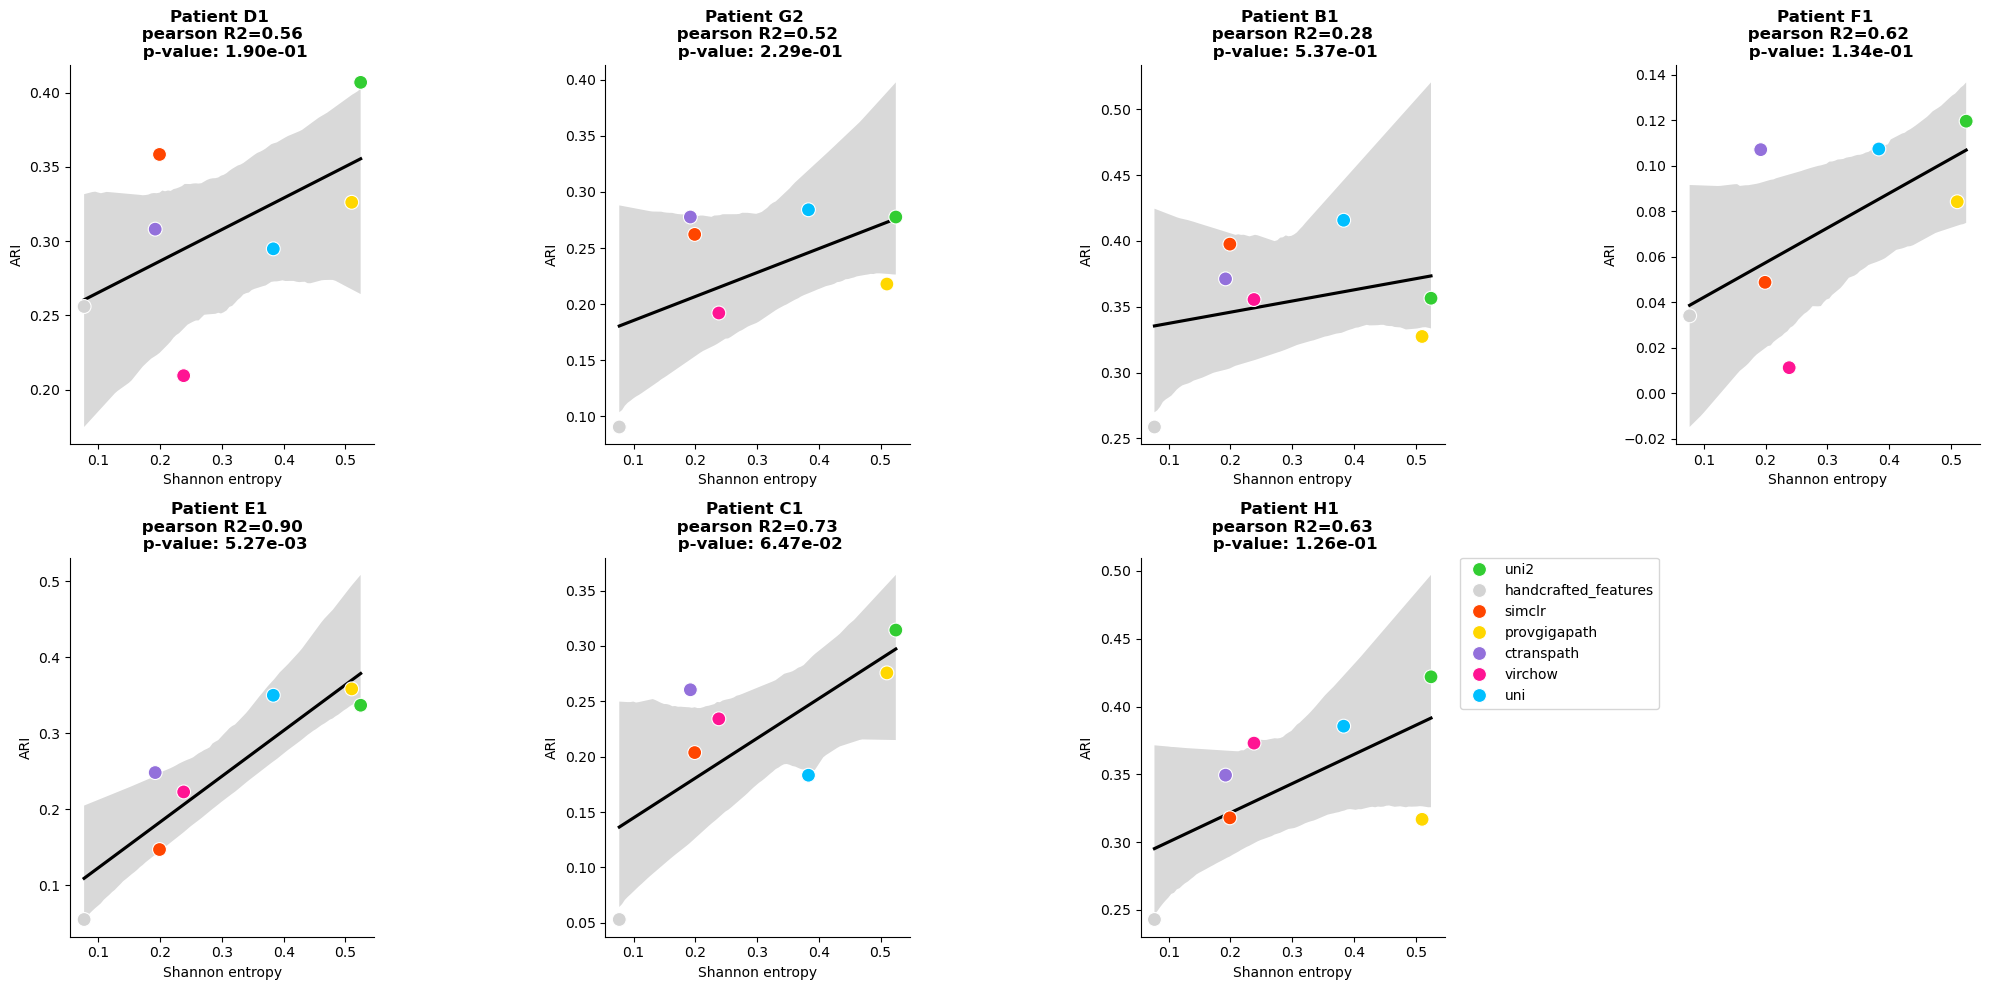

In [35]:
# Shannon vs ARI per patient
df_model_summary2 = df_comp[df_comp["clustering"] == 'umap'].merge(df_shannon, left_on='model', right_index=True, how='left')
n_patients = len(df_model_summary2['patient'].unique())
plt.figure(figsize=(20, 10))
for i, patient in enumerate(df_model_summary2['patient'].unique()):
    sub_df = df_model_summary2[df_model_summary2['patient'] == patient]

    s, p = pearsonr(sub_df['shannon_entropy'], sub_df['ari'])
    plt.subplot(2, int(np.ceil(n_patients/2)), i+1)
    sns.regplot(data=sub_df, x='shannon_entropy', y='ari', color='black')
    sns.scatterplot(data=sub_df, x='shannon_entropy', y='ari', hue=sub_df['model'],
                    palette=base_model_palette, s=100, zorder=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Shannon entropy')
    plt.ylabel('ARI')
    plt.title(f'Patient {patient} \n pearson R2={s:.2f} \n p-value: {p:.2e}', weight='bold')
    sns.despine()

    if i != 6:
        plt.legend().remove()
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], "Figure2/overall_shannon_vs_ari_per_patient.pdf"), bbox_inches='tight')


In [36]:
with open(os.path.join(config['base_benchmark_folder'], "shannon_entropy", "shannon_entropy_per_tumor_all_comps_raw.json")) as f:
    shannon_per_patient = json.load(f)
df_shannon_per_patient = pd.DataFrame.from_dict(shannon_per_patient, orient='index')
df_shannon_per_patient

df_model_summary2 = df_comp[df_comp["clustering"] == 'umap'].merge(df_shannon_per_patient, left_on='patient', right_index=True, how='left')

df_shannon_per_patient_melted = pd.melt(df_shannon_per_patient, var_name='patient', value_name='shannon_entropy_per_patient')
df_shannon_per_patient_melted['model'] = list(df_shannon_per_patient.index) * len(df_shannon_per_patient.columns)

if config['dataset'] == 'HER2':
    df_comp['patient'] = df_comp['patient'].apply(lambda x: x[0])
else:
    df_comp['patient'] = df_comp['patient'].apply(lambda x: x.split('_')[0])
    
df_shannon_per_patient_melted["model"] = df_shannon_per_patient_melted["model"].apply(lambda x: x.replace("handcrafted", "handcrafted_features"))

df_model_summary2 = df_comp[df_comp["clustering"] == 'umap'].merge(df_shannon_per_patient_melted, on=['patient', 'model'])

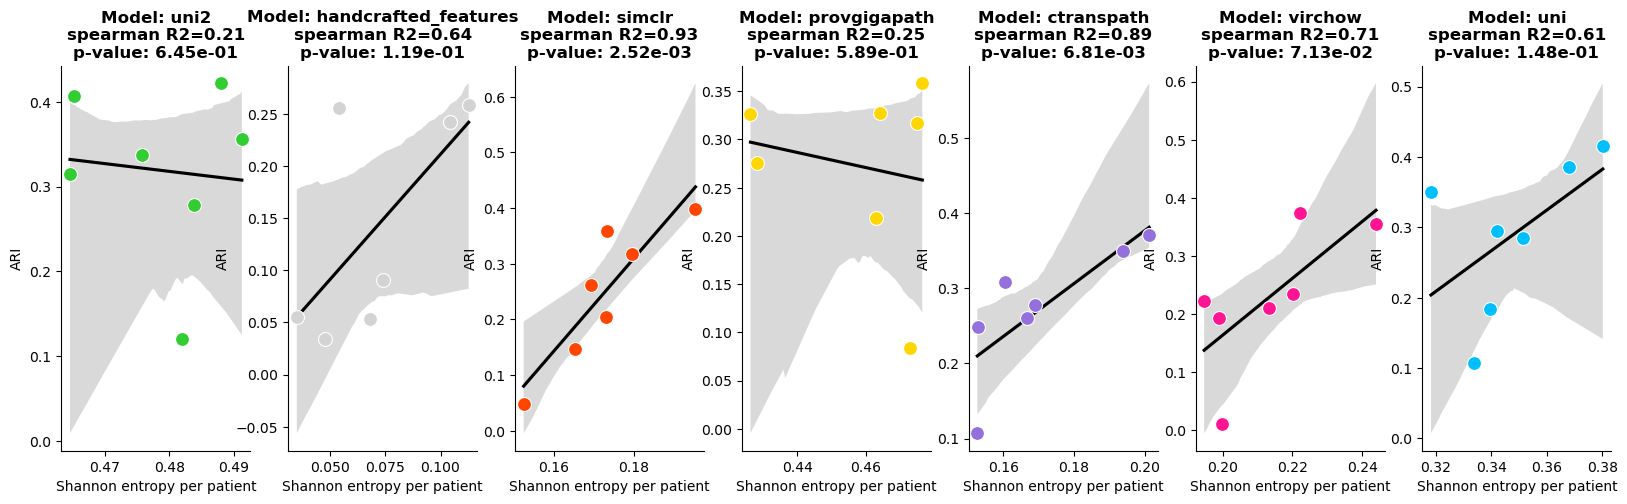

In [37]:
plt.figure(figsize=(20, 5))
for i, model in enumerate(df_model_summary2['model'].unique()):
    plt.subplot(1, len(df_model_summary2['model'].unique()), i+1)
    sub_df = df_model_summary2[df_model_summary2['model'] == model]
    s, p = spearmanr(sub_df['shannon_entropy_per_patient'], sub_df['ari'])
    sns.regplot(data=sub_df, x='shannon_entropy_per_patient', y='ari', color='black')
    sns.scatterplot(data=sub_df, x='shannon_entropy_per_patient', y='ari', color=config['base_model_palette'][model], s=100, zorder=2)
    plt.xlabel('Shannon entropy per patient')
    plt.ylabel('ARI')
    plt.title(f'Model: {model}\nspearman R2={s:.2f}\np-value: {p:.2e}', weight='bold')
    sns.despine()
    plt.savefig(os.path.join(config['figures_folder'], f"Figure2/shannon_entropy_vs_ari_per_patient_{model}.pdf"), bbox_inches='tight')

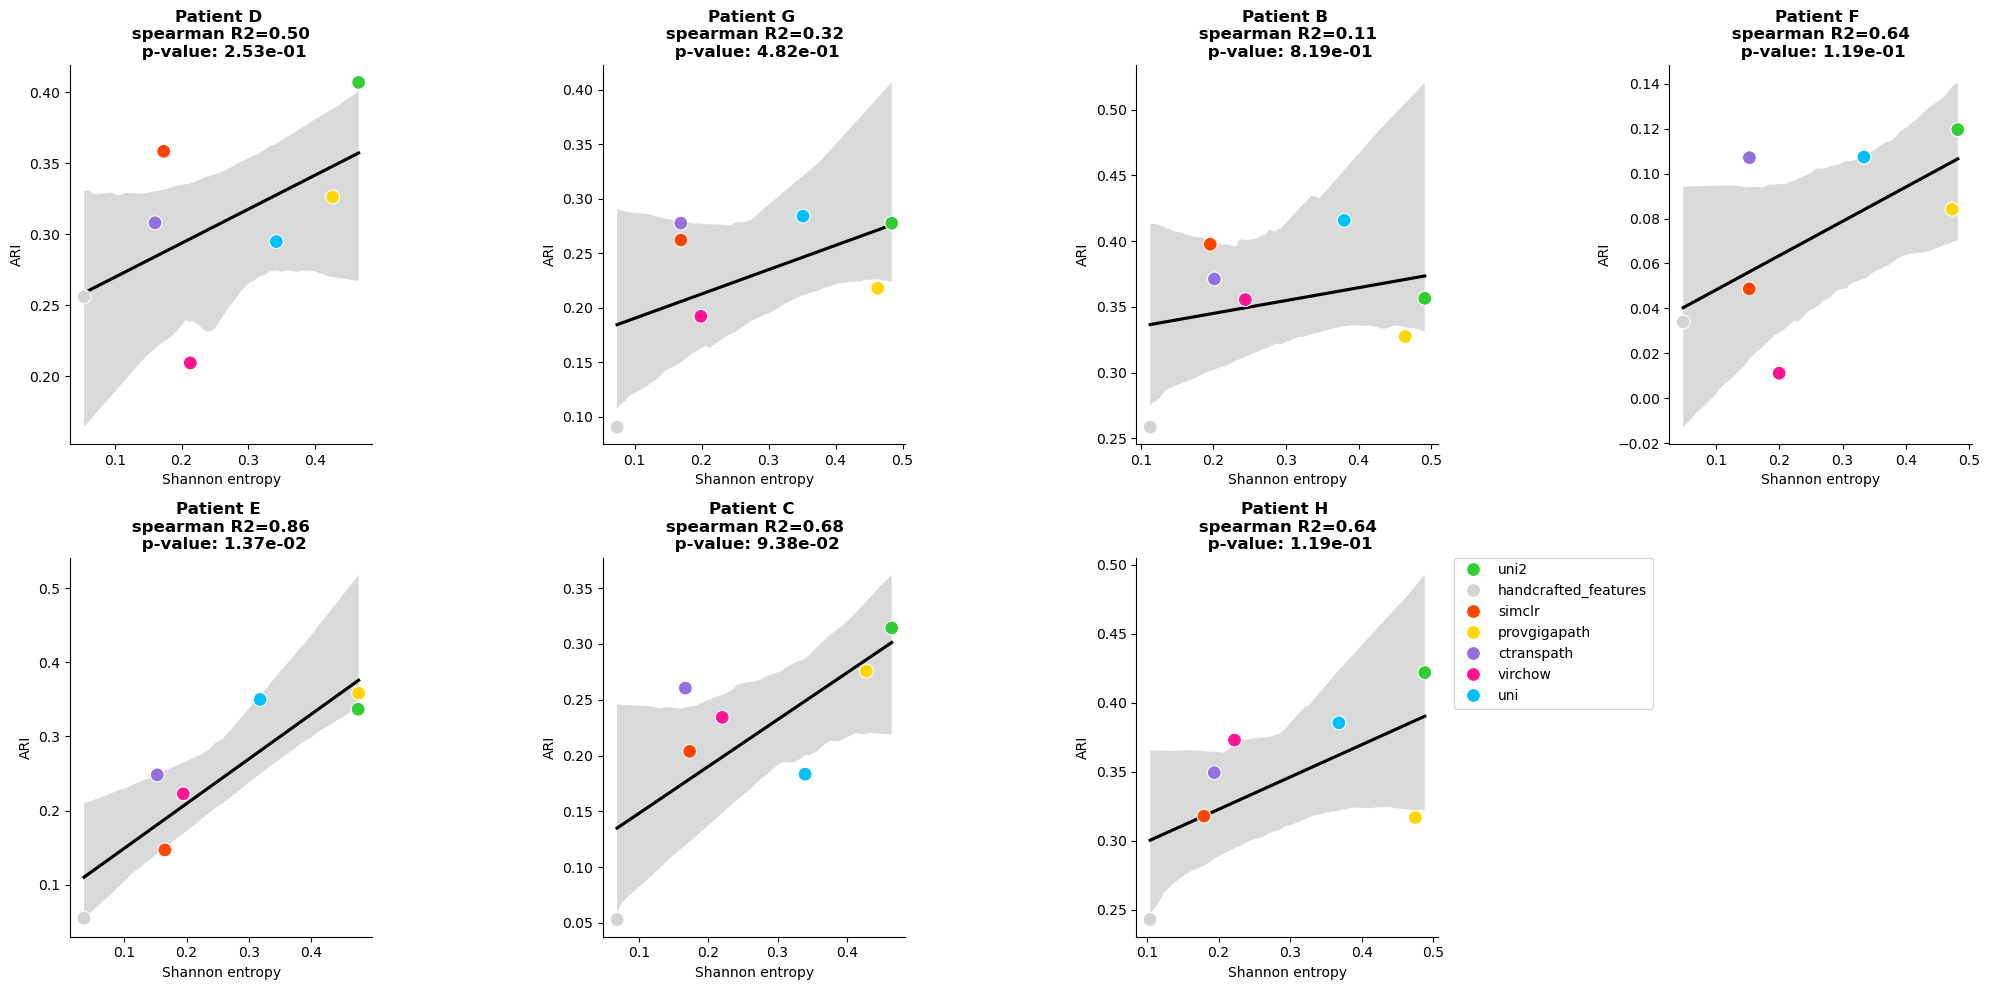

In [38]:
plt.figure(figsize=(20, 10))
for i, patient in enumerate(df_model_summary2['patient'].unique()):
    sub_df = df_model_summary2[df_model_summary2['patient'] == patient]

    s, p = spearmanr(sub_df['shannon_entropy_per_patient'], sub_df['ari'])
    plt.subplot(2, 4, i+1)
    sns.regplot(data=sub_df, x='shannon_entropy_per_patient', y='ari', color='black')
    sns.scatterplot(data=sub_df, x='shannon_entropy_per_patient', y='ari', hue=sub_df['model'],
                    palette=base_model_palette, s=100, zorder=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Shannon entropy')
    plt.ylabel('ARI')
    plt.title(f'Patient {patient} \n spearman R2={s:.2f} \n p-value: {p:.2e}', weight='bold')
    sns.despine()

    if i != 6:
        plt.legend().remove()
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_per_patient_vs_ari_per_patient.pdf"), bbox_inches='tight')

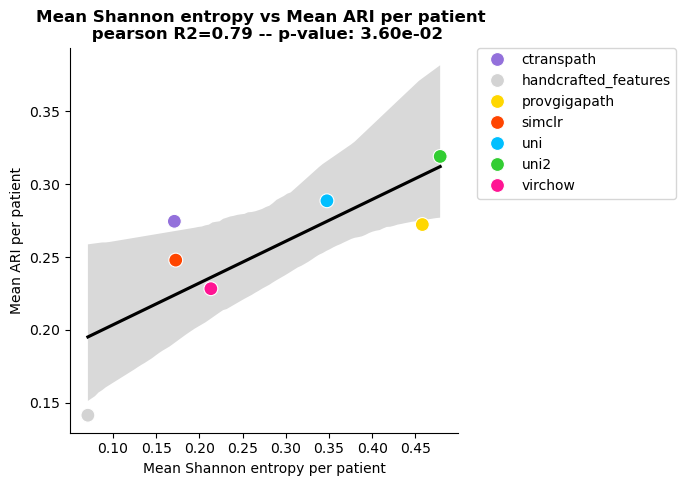

In [39]:
mean_vs_mean = df_model_summary2.groupby('model').mean(numeric_only=True)

s, p = pearsonr(mean_vs_mean['shannon_entropy_per_patient'], mean_vs_mean['ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=mean_vs_mean, x='shannon_entropy_per_patient', y='ari', color='black')
sns.scatterplot(data=mean_vs_mean, x='shannon_entropy_per_patient', y='ari', hue=mean_vs_mean.index,
                palette=base_model_palette, s=100, zorder=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Mean Shannon entropy per patient')
plt.ylabel('Mean ARI per patient')
plt.title(f'Mean Shannon entropy vs Mean ARI per patient \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure2/mean_shannon_entropy_vs_mean_ari.pdf"), bbox_inches='tight')

Model: uni, Type: C1, Dist: 0.001
Model: uni2, Type: C1, Dist: 0.001
Model: virchow, Type: C1, Dist: 0.001
Model: provgigapath, Type: C1, Dist: 0.001
Model: ctranspath, Type: C1, Dist: 0.001
Model: simclr, Type: C1, Dist: 0.001
Model: uni, Type: E1, Dist: 0.001
Model: uni2, Type: E1, Dist: 0.001
Model: virchow, Type: E1, Dist: 0.001
Model: provgigapath, Type: E1, Dist: 0.001
Model: ctranspath, Type: E1, Dist: 0.001
Model: simclr, Type: E1, Dist: 0.001
Model: uni, Type: D1, Dist: 0.001
Model: uni2, Type: D1, Dist: 0.001
Model: virchow, Type: D1, Dist: 0.001
Model: provgigapath, Type: D1, Dist: 0.001
Model: ctranspath, Type: D1, Dist: 0.001
Model: simclr, Type: D1, Dist: 0.001
Model: uni, Type: G2, Dist: 0.001
Model: uni2, Type: G2, Dist: 0.001
Model: virchow, Type: G2, Dist: 0.001
Model: provgigapath, Type: G2, Dist: 0.001
Model: ctranspath, Type: G2, Dist: 0.001
Model: simclr, Type: G2, Dist: 0.001
Model: uni, Type: H1, Dist: 0.001
Model: uni2, Type: H1, Dist: 0.001
Model: virchow, Typ

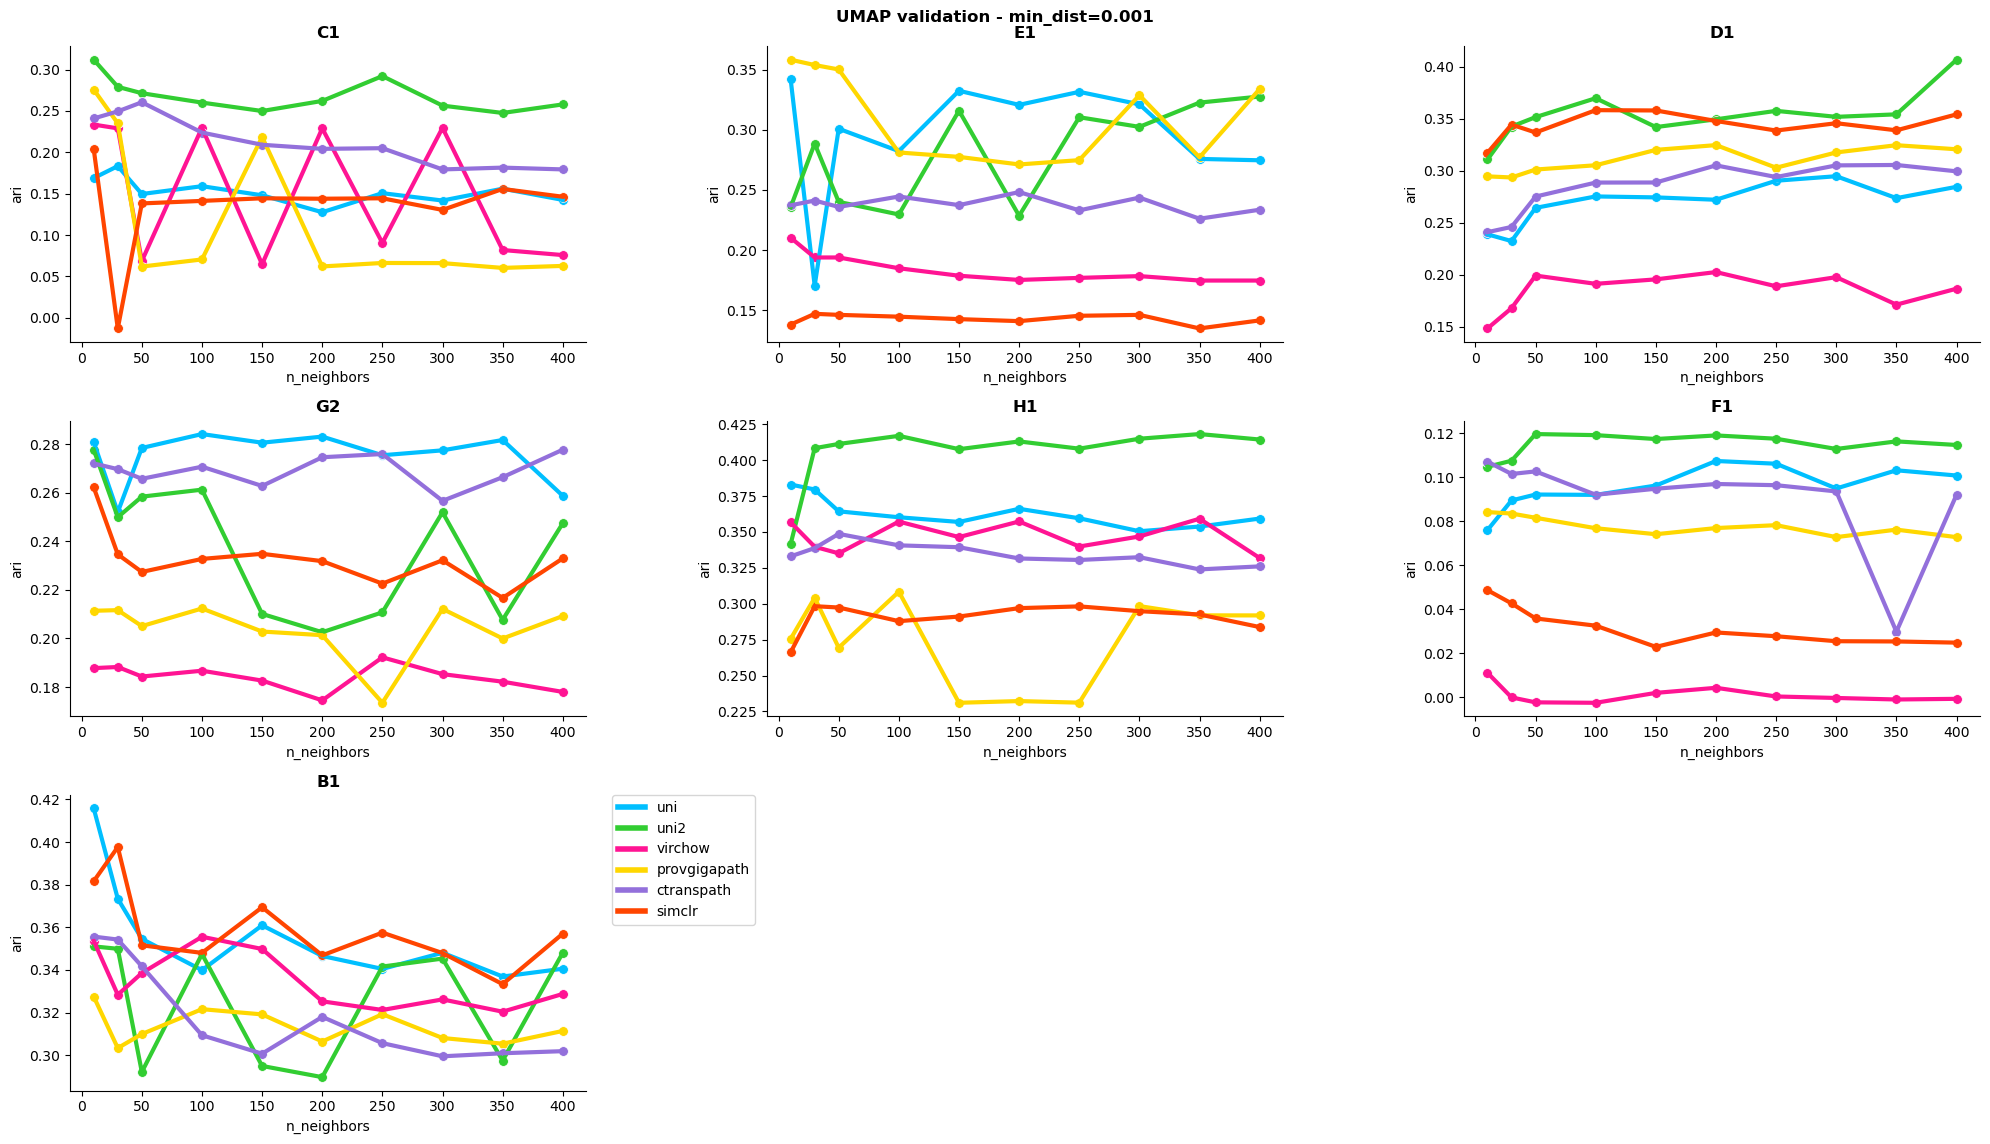

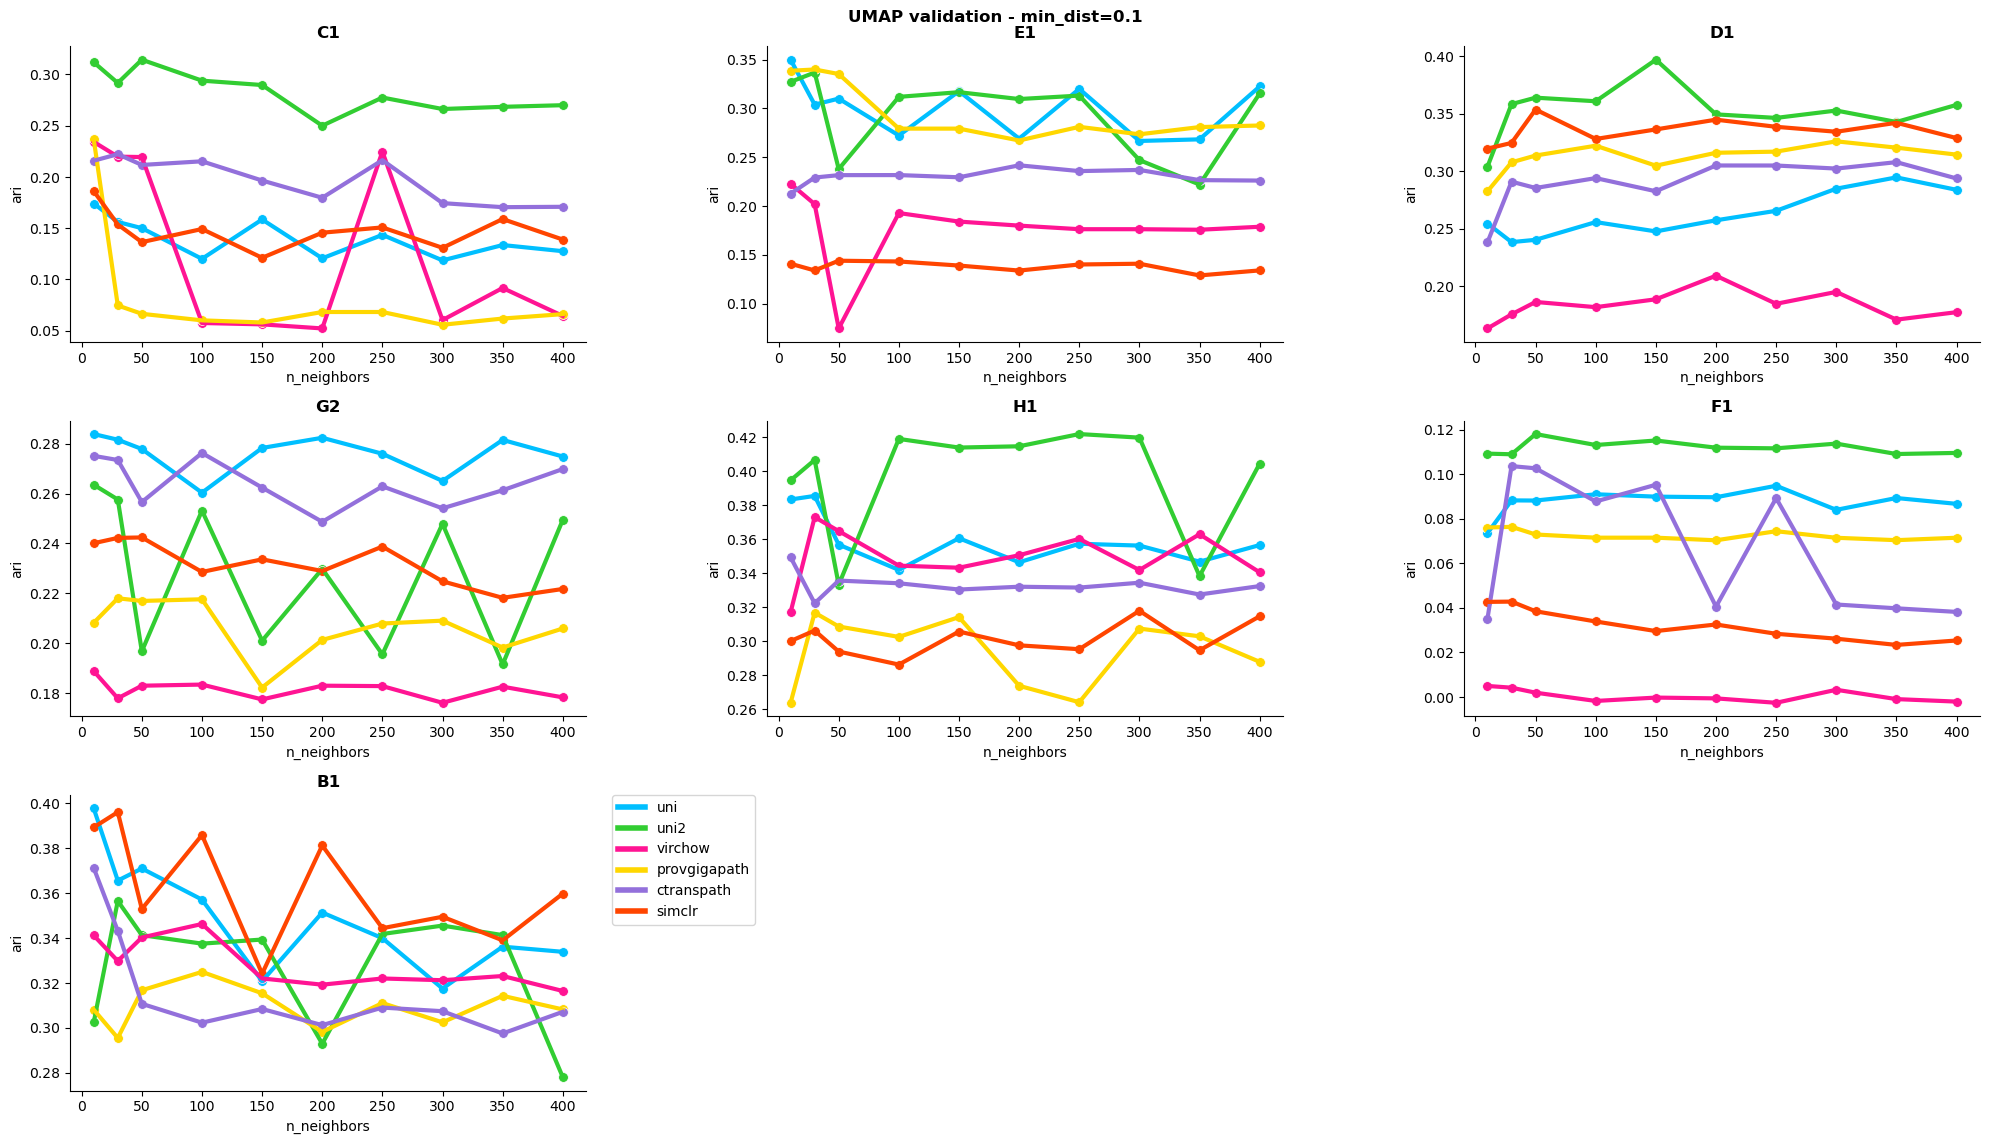

In [40]:
# UMAP validation parameters
import glob 

for dist in [0.001, 0.1]:
    plt.figure(figsize=(20, 15))
    for i, type in enumerate(umap_clust[base_model_list[0]].keys()):
        plt.subplot(4, 3, i+1)
        
        filenames = []
        for model in base_model_palette.keys():
            if (model != 'scMTOP') & (model != 'handcrafted') & (model != 'handcrafted_features'):
                print(f"Model: {model}, Type: {type}, Dist: {dist}")
                filename = glob.glob(os.path.join(config['base_benchmark_folder'], 'unsupervised_clustering_ARI', "kmeans", f"UMAP_validation_{model}_{type}*.csv"))[0]
                filenames.append(filename)

                df_ = pd.read_csv(filename, index_col=0)
                
                sns.scatterplot(x=df_[df_['min_dist'] == dist]['n_neighbors'], 
                                y=df_[df_['min_dist'] == dist]['ari'], 
                                label=f"{model} - {type}",  
                                s=50, 
                                color=base_model_palette[model], legend=False)
                
                sns.lineplot(x=df_[df_['min_dist'] == dist]['n_neighbors'], y=df_[df_['min_dist'] == dist]['ari'], 
                             label=f"{model} - {type}", 
                             color=base_model_palette[model],
                             linewidth=3, legend=False)

                plt.legend().remove()
            plt.title(type, weight='bold')
        
    handles = [plt.Line2D([0], [0], color=base_model_palette[model], lw=4) for model in base_model_list]
    plt.legend(handles, base_model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)        
    sns.despine()
    plt.suptitle(f"UMAP validation - min_dist={dist}", weight='bold')
    plt.tight_layout()
        
    plt.savefig(os.path.join(config['figures_folder'], "Figure2/UMAP_parameters_validation_mindist_{dist}.pdf"), bbox_inches='tight')

## Correlation with the number of parameters

In [41]:
parameters = {'provgigapath': 1135, 'uni2': 681, 'virchow': 632, 'uni': 303, 'ctranspath': 28, 'simclr': 24}
embedding_size = {'provgigapath': 1536, 'uni2': 1536, 'virchow': 1280, 'uni': 1024, 'ctranspath': 768, 'simclr': 512}

In [42]:
df_shannon

df_parameters = pd.DataFrame.from_dict(parameters, orient='index', columns=['n_parameters'])
df_parameters = df_parameters.merge(df_shannon, left_index=True, right_index=True)

df_embedding_size = pd.DataFrame.from_dict(embedding_size, orient='index', columns=['embedding_size'])
df_embedding_size = df_embedding_size.merge(df_shannon, left_index=True, right_index=True)

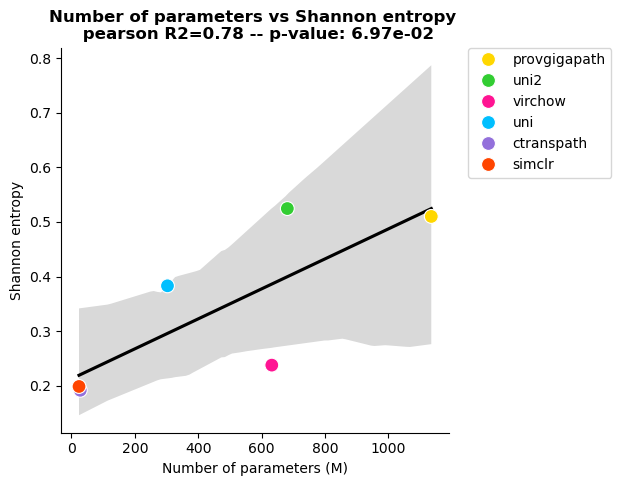

In [43]:
# Compute pearson correlation
s, p = pearsonr(df_parameters['n_parameters'], df_parameters['shannon_entropy'])
plt.figure(figsize=(5, 5))
sns.regplot(df_parameters, x='n_parameters', y='shannon_entropy', color='black')
sns.scatterplot(df_parameters, x='n_parameters', y='shannon_entropy', hue=df_parameters.index, palette=base_model_palette, s=100, zorder=2)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of parameters (M)')
plt.ylabel('Shannon entropy')
plt.title(f"Number of parameters vs Shannon entropy \n pearson R2={s:.2f} -- p-value: {p:.2e}", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure2/embedding_size_vs_shannon_entropy.pdf"), bbox_inches='tight')

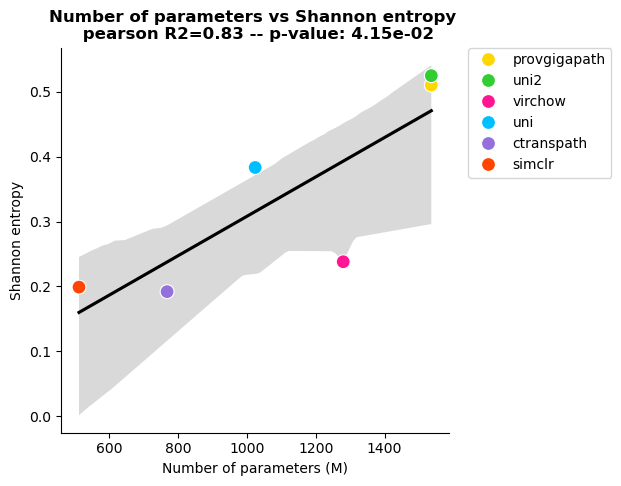

In [44]:
# Compute pearson correlation
s, p = pearsonr(df_embedding_size['embedding_size'], df_embedding_size['shannon_entropy'])
plt.figure(figsize=(5, 5))
sns.regplot(df_embedding_size, x='embedding_size', y='shannon_entropy', color='black')
sns.scatterplot(df_embedding_size, x='embedding_size', y='shannon_entropy', hue=df_embedding_size.index, palette=base_model_palette, s=100, zorder=2)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of parameters (M)')
plt.ylabel('Shannon entropy')
plt.title(f"Number of parameters vs Shannon entropy \n pearson R2={s:.2f} -- p-value: {p:.2e}", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure2/number_of_parameters_vs_shannon_entropy.pdf"), bbox_inches='tight')

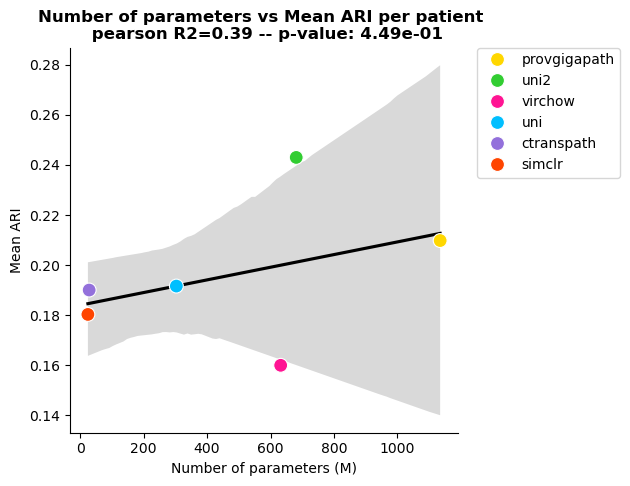

In [45]:
df_parameters = df_parameters.merge(df_model_summary[['mean_ari']], left_index=True, right_index=True)
s, p = pearsonr(df_parameters['n_parameters'], df_parameters['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(df_parameters, x='n_parameters', y='mean_ari', color='black')
sns.scatterplot(df_parameters, x='n_parameters', y='mean_ari', hue=df_parameters.index, palette=base_model_palette, s=100, zorder=2)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of parameters (M)')
plt.ylabel('Mean ARI')
plt.title(f"Number of parameters vs Mean ARI per patient \n pearson R2={s:.2f} -- p-value: {p:.2e}", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure2/number_of_parameters_vs_mean_ari.pdf"), bbox_inches='tight')

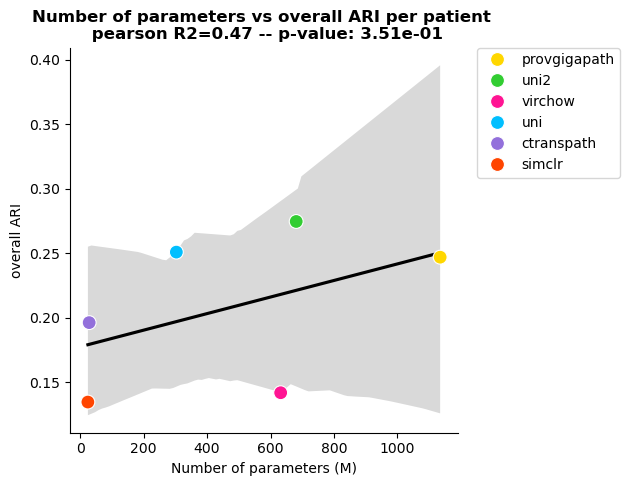

In [46]:
df_parameters = df_parameters.merge(df_model_summary[['overall_ari']], left_index=True, right_index=True)
s, p = pearsonr(df_parameters['n_parameters'], df_parameters['overall_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(df_parameters, x='n_parameters', y='overall_ari', color='black')
sns.scatterplot(df_parameters, x='n_parameters', y='overall_ari', hue=df_parameters.index, palette=base_model_palette, s=100, zorder=2)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of parameters (M)')
plt.ylabel('overall ARI')
plt.title(f"Number of parameters vs overall ARI per patient \n pearson R2={s:.2f} -- p-value: {p:.2e}", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure2/number_of_parameters_vs_overall_ari.pdf"), bbox_inches='tight')

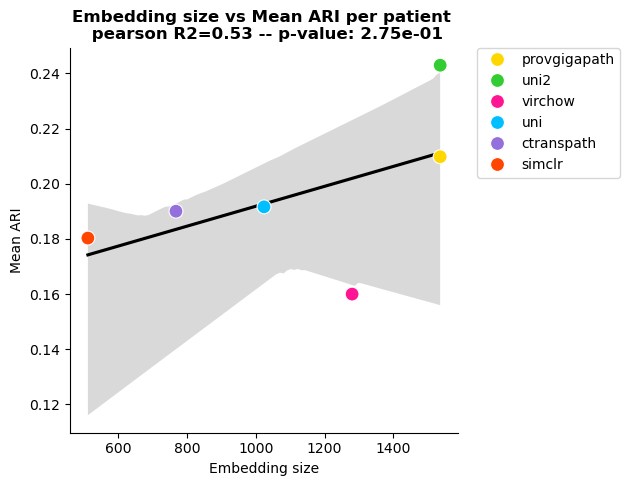

In [47]:
df_embedding_size = df_embedding_size.merge(df_model_summary[['mean_ari']], left_index=True, right_index=True)
s, p = pearsonr(df_embedding_size['embedding_size'], df_embedding_size['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(df_embedding_size, x='embedding_size', y='mean_ari', color='black')
sns.scatterplot(df_embedding_size, x='embedding_size', y='mean_ari', hue=df_embedding_size.index, palette=base_model_palette, s=100, zorder=2)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Embedding size')
plt.ylabel('Mean ARI')
plt.title(f"Embedding size vs Mean ARI per patient \n pearson R2={s:.2f} -- p-value: {p:.2e}", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure2/embedding_size_vs_mean_ari.pdf"), bbox_inches='tight')